# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modules used for clustering time series
import tslearn as ts
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Modules used for preprocessing
from datetime import datetime
import preprocess

# Module for suppressing warnings.
import warnings 
warnings.filterwarnings('ignore')

/Users/gauravpendharkar/electricity-forecasting/forecasting/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Data preprocessing

In [ ]:
a = preprocess.preprocess_modelling(as_numpy=True, clustered = False)
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered = False)

# Data Standardization

In [3]:
a = TimeSeriesScalerMeanVariance().fit_transform(a)

# K-Means Clustering

606.824 --> 454.592 --> 454.529 --> 454.529 --> 
580.757 --> 428.278 --> 423.601 --> 421.009 --> 419.424 --> 417.788 --> 415.916 --> 415.628 --> 415.628 --> 
560.742 --> 408.219 --> 405.547 --> 402.537 --> 399.073 --> 397.474 --> 395.164 --> 392.938 --> 390.727 --> 390.200 --> 390.088 --> 389.967 --> 389.912 --> 389.859 --> 389.821 --> 389.821 --> 
551.591 --> 397.048 --> 392.310 --> 389.474 --> 386.295 --> 384.449 --> 382.528 --> 380.668 --> 378.776 --> 376.920 --> 376.811 --> 376.811 --> 
544.158 --> 384.093 --> 378.647 --> 374.459 --> 372.700 --> 370.322 --> 369.511 --> 369.250 --> 369.119 --> 368.993 --> 368.927 --> 368.868 --> 368.801 --> 368.768 --> 368.768 --> 
519.626 --> 376.126 --> 369.689 --> 366.942 --> 364.128 --> 362.778 --> 359.118 --> 353.287 --> 350.406 --> 350.100 --> 350.100 --> 


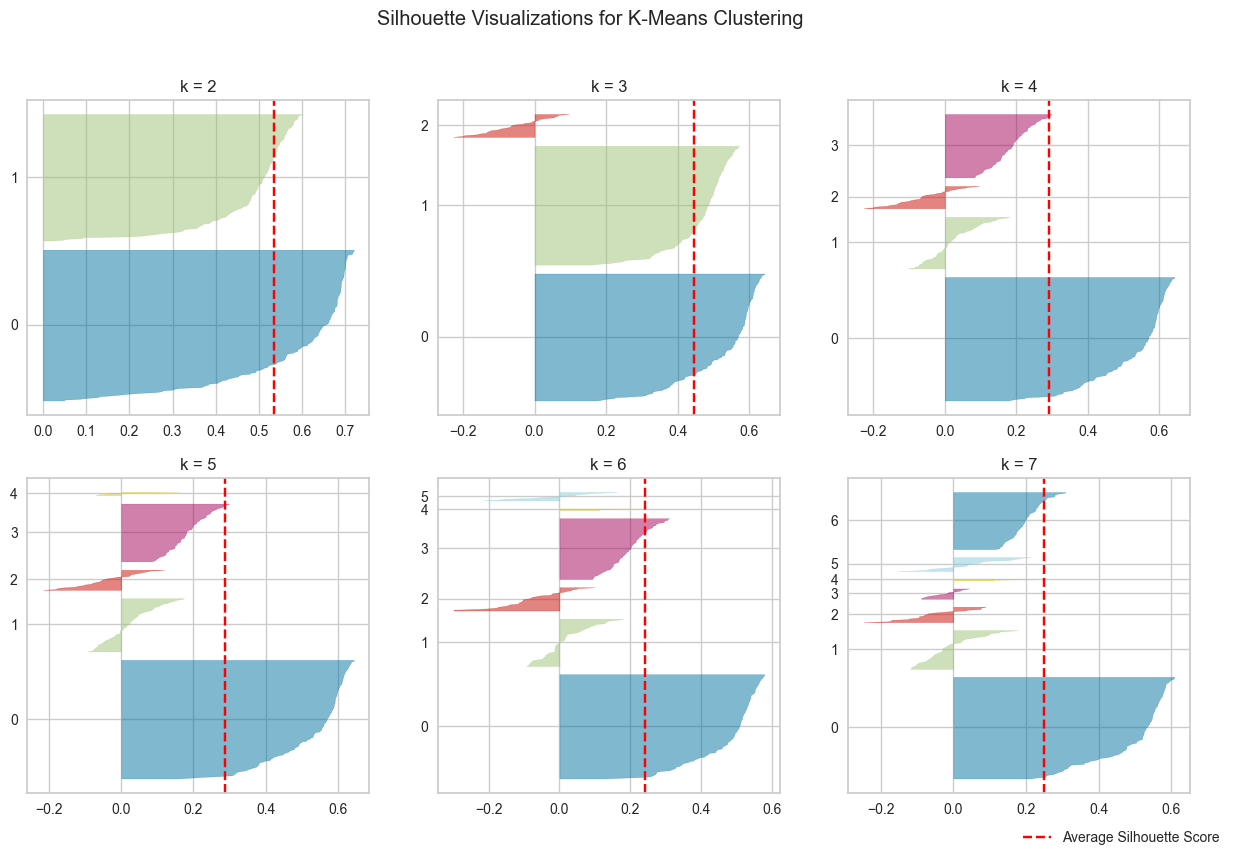

In [93]:
score = []
fig, ax = plt.subplots(2, 3, figsize=(15,9))

for k in range(2, 8):
    km = TimeSeriesKMeans(n_clusters = k, verbose = True, random_state = 42)
    y_pred = km.fit_predict(a)

    #init.append(km.inertia_)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[(k - 2)//3][(k - 2)%3])
    visualizer.fit(a.reshape(333, 1462))
    ax[(k - 2)//3][(k - 2)%3].set_title(f"k = {k}")
    ax[(k - 2)//3][(k - 2)%3].set_yticks(ticks = visualizer.y_tick_pos_,
                                         labels = list(range(0, k)))
plt.suptitle("Silhouette Visualizations for K-Means Clustering")
plt.subplots_adjust(hspace=0.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.8, -0.08))
plt.yticks()
plt.show()

- It is evident that k = 2 is the best value for hyperparameter k for K-means clustering. This is because:

1. The average silhouette score is the highest and relatively closest to 1.
2. There are no negative values for silhouette score indicating that each time series was allotted a well-matched cluster.
3. The shape of the plots for each cluster is pretty consistent.

- As, the value of k increases, there are inconsistencies in shapes of the plots for each cluster. 

- Moreover, negative values exist for each of the clusters and the average score is closer to 0.

- This implies that these are not clustering the time series data well.

# K-Shape Clustering

0.047 --> 0.048 --> 
0.043 --> 0.042 --> 0.042 --> 
0.041 --> 0.040 --> 0.040 --> 0.040 --> 
0.035 --> 0.035 --> 0.035 --> 0.035 --> 
0.033 --> 0.032 --> 0.032 --> 0.032 --> 0.032 --> 
Resumed because of empty cluster
0.031 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 


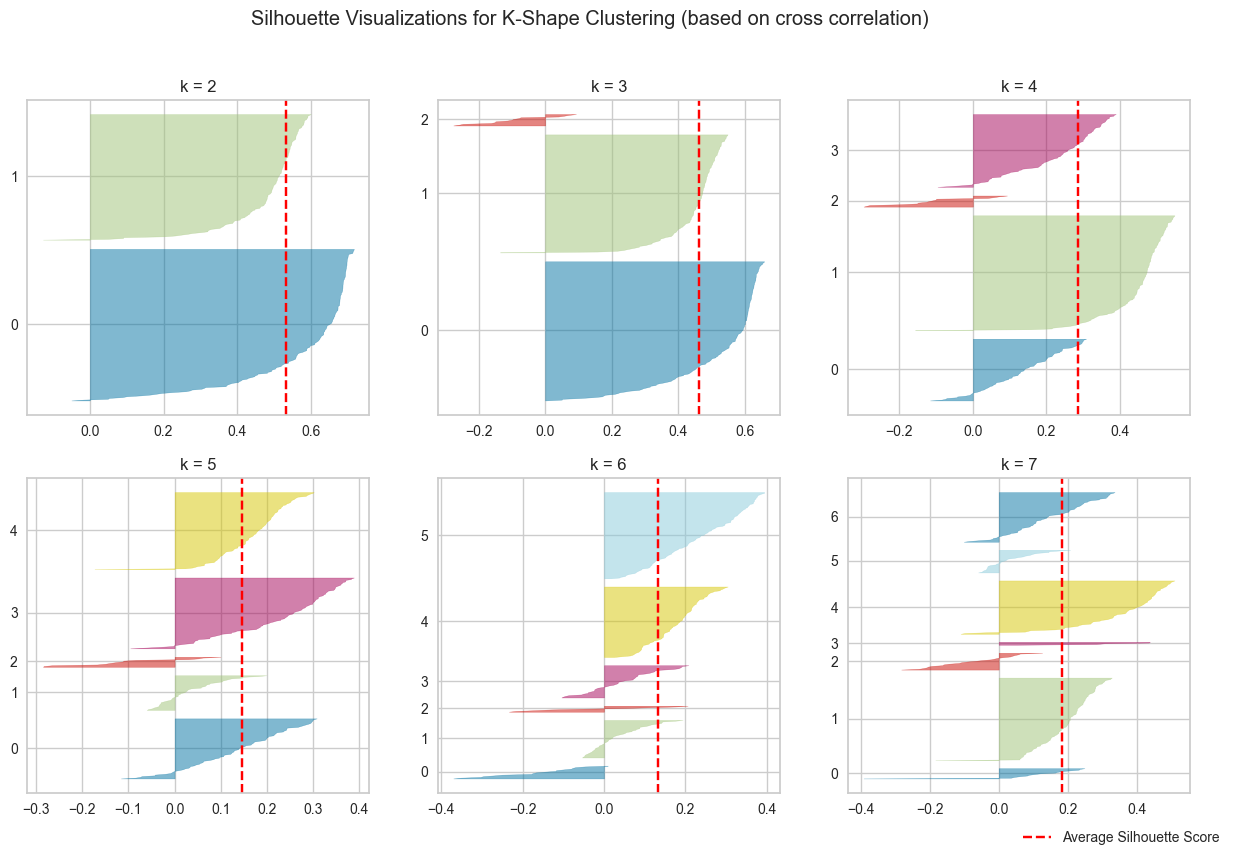

In [95]:
score = []
fig, ax = plt.subplots(2, 3, figsize=(15,9))

for k in range(2, 8):
    ks = KShape(n_clusters = k, verbose = True, random_state = 42)
    y_pred = ks.fit_predict(a)

    #init.append(km.inertia_)
    visualizer = SilhouetteVisualizer(ks, colors='yellowbrick', ax=ax[(k - 2)//3][(k - 2)%3])
    visualizer.fit(a.reshape(333, 1462))
    ax[(k - 2)//3][(k - 2)%3].set_title(f"k = {k}")
    ax[(k - 2)//3][(k - 2)%3].set_yticks(ticks = visualizer.y_tick_pos_,
                                         labels = list(range(0, k)))
plt.suptitle("Silhouette Visualizations for K-Shape Clustering (based on cross correlation)")
plt.subplots_adjust(hspace=0.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.8, -0.08))
plt.yticks()
plt.show()

The inference is similar to that of K-Mean clustering.

# Clusters for k = 2

606.824 --> 454.592 --> 454.529 --> 454.529 --> 


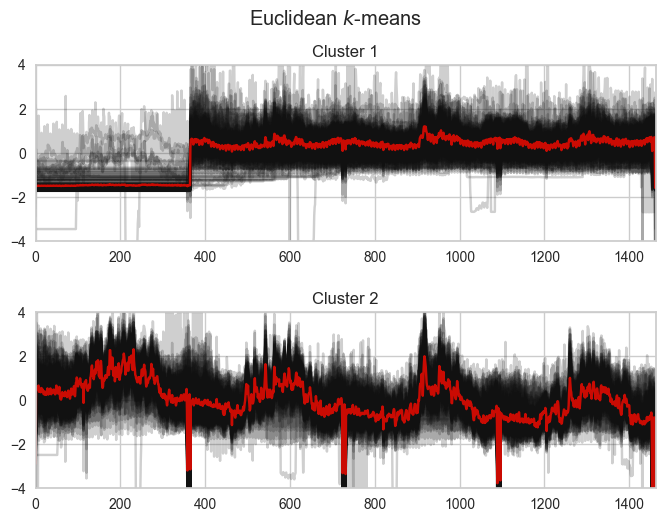

In [97]:
km = TimeSeriesKMeans(n_clusters = 2, verbose = True, random_state = 42)
y_pred = km.fit_predict(a)

fig, axs = plt.subplots(2)
for yi in range(2):
    c = 0
    for xx in a[y_pred == yi]:
        axs[yi].plot(xx.ravel(), "k-", alpha=.2)
    axs[yi].plot(km.cluster_centers_[yi].ravel(), "r-")
    axs[yi].set_xlim(0, a.shape[1])
    axs[yi].set_ylim(-4, 4)
    axs[yi].set_title(f"Cluster {yi + 1}")
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Euclidean $k$-means")
plt.show()

# Storing the clusters

In [105]:
temp = list(zip(y_pred, [i for i in electricity.columns if i != "date"]))
clusters = dict()

for i in temp:
    cluster_id, cust = i
    if cluster_id not in clusters:
        clusters[int(cluster_id)] = [cust]
    else:
        clusters[int(cluster_id)].append(cust)

# Saving the clusters in JSON file

In [109]:
with open("clusters.json", "w") as f:
    json.dump(clusters, f, indent = 4)